In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import shap
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
import re


In [61]:
data_reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
data_orders = pd.read_csv('../data/olist_orders_dataset.csv')
data_customers = pd.read_csv('../data/olist_customers_dataset.csv')
data_order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
data_sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
data_products = pd.read_csv('../data/olist_products_dataset.csv')
data_categories = pd.read_csv('../data/product_category_name_translation.csv')
data_geolocation = pd.read_csv('../data/olist_geolocation_dataset.csv')
data_payments = pd.read_csv('../data/olist_order_payments_dataset.csv')


In [62]:
# --- AGREGACIÓN DE PAGOS ---
payments_agg = data_payments.groupby('order_id').agg({
    'payment_installments': 'max',    # Máximo de cuotas (presión financiera)
    'payment_value': 'sum',           # Valor total pagado
    'payment_type': lambda x: x.mode()[0] if not x.empty else 'unknown' # Tipo predominante
}).reset_index()

# --- LIMPIEZA DE GEOLOCALIZACIÓN ---
# Promediamos lat/lng por prefijo para tener un solo punto por zona
geo_clean = data_geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()


In [63]:
# Merge datasets to create a comprehensive "Maestro" dataset
df_maestro = data_reviews.merge(data_orders, on='order_id', how='inner')
# Merge with order_items
df_maestro = df_maestro.merge(data_order_items, on='order_id', how='inner')
# If no date fill with a default value (e.g., 1970-01-01) to avoid issues with date calculations
df_maestro['order_delivered_customer_date'] = pd.to_datetime(df_maestro['order_delivered_customer_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_estimated_delivery_date'] = pd.to_datetime(df_maestro['order_estimated_delivery_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_delivered_carrier_date'] = pd.to_datetime(df_maestro['order_delivered_carrier_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_purchase_timestamp'] = pd.to_datetime(df_maestro['order_purchase_timestamp']).fillna(pd.Timestamp('1970-01-01'))

# Calculate delivery delta in days
df_maestro['delivery_delta_days'] = (df_maestro['order_delivered_customer_date'] - 
                                    df_maestro['order_estimated_delivery_date']).dt.days
# Calculate seller dispatch days 
df_maestro['seller_dispatch_days'] = (df_maestro['order_delivered_carrier_date'] - 
                                   df_maestro['order_purchase_timestamp']).dt.days
# Calculate carrier transit days
df_maestro['carrier_transit_days'] = (df_maestro['order_delivered_customer_date'] - 
                                   df_maestro['order_delivered_carrier_date']).dt.days  

# Merge review_comment_message and review_comment_title into a single column for analysis
df_maestro['full_text'] = df_maestro['review_comment_title'].fillna('') + ' ' + df_maestro['review_comment_message'].fillna('')



In [64]:
# Merge Payments Info with (order_id) to get financial features
df_maestro = df_maestro.merge(payments_agg, on='order_id', how='left')

# Merge Customer Info with (customer_id) to get customer features
df_maestro = df_maestro.merge(data_customers[['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']], 
                              on='customer_id', how='left')

# Merge Seller Info with (seller_id) to get seller features
df_maestro = df_maestro.merge(data_sellers[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']], 
                              on='seller_id', how='left')
# Merge Product Info with (product_id) to get product features
df_maestro = df_maestro.merge(data_products, on='product_id', how='left')

# Merge Geolocation of the customer
df_maestro = df_maestro.merge(
    geo_clean, 
    left_on='customer_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', how='left').rename(columns={'geolocation_lat': 'geo_lat_customer', 'geolocation_lng': 'geo_lng_customer'}).drop(columns=['geolocation_zip_code_prefix'])

# Merge Geolocation of the seller
df_maestro = df_maestro.merge(
    geo_clean, 
    left_on='seller_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', how='left').rename(
    columns={'geolocation_lat': 'geo_lat_seller', 'geolocation_lng': 'geo_lng_seller'}).drop(columns=['geolocation_zip_code_prefix'])

In [65]:
def calculate_euclidean_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia euclidiana simple entre dos puntos
    """
    deg_to_km_factor = 111.1
    euclidean_dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
    return euclidean_dist * deg_to_km_factor

# Crear la columna de distancia
df_maestro['distance_seller_customer_km'] = calculate_euclidean_distance(
    df_maestro['geo_lat_customer'], 
    df_maestro['geo_lng_customer'], 
    df_maestro['geo_lat_seller'],
    df_maestro['geo_lng_seller'])

In [66]:
def calculate_stats_per_row (data, column):
    data[column] = data[column].fillna('')
    
    # Cantidad de caracteres
    data['char_count'] = data[column].str.len()
    
    # Cantidad de palabras
    data['word_count'] = data[column].apply(lambda x: len(x.split()))
    
    # Cantidad de oraciones (aproximado por puntos, signos de exclamación e interrogación)
    data['sentence_count'] = data[column].apply(
        lambda x: max(1, len(re.split(r'[.!?]+', x.strip())) - 1)
    )
    
    # Longitud promedio de palabras
    data['avg_word_length'] = data[column].apply(
        lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0
    )
    
    # Palabras por oración
    data['words_per_sentence'] = data['word_count'] / data['sentence_count']
    
    # Palabras únicas
    data['unique_words_count'] = data[column].apply(
        lambda x: len(set(x.lower().split()))
    )
    # Signos de exclamación
    data['exclamation_count'] = data[column].str.count('!')
    
    # Signos de interrogación
    data['question_count'] = data[column].str.count(r'\?')
    
    # Comas
    data['comma_count'] = data[column].str.count(',')
    
    # Puntos
    data['period_count'] = data[column].str.count(r'\.')
    return data

df_maestro['full_text'] = df_maestro['review_comment_title'].fillna('') + '' + df_maestro['review_comment_message'].fillna('')
calculate_stats_per_row(df_maestro, 'full_text')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,char_count,word_count,sentence_count,avg_word_length,words_per_sentence,unique_words_count,exclamation_count,question_count,comma_count,period_count
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,0,0,1,0.000000,0.0,0,0,0,0,0
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,0,0,1,0.000000,0.0,0,0,0,0,0
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,0,0,1,0.000000,0.0,0,0,0,0,0
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,0,0,1,0.000000,0.0,0,0,0,0,0
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,37,6,1,5.333333,6.0,6,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112367,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,2018-06-27 17:31:29,...,0,0,1,0.000000,0.0,0,0,0,0,0
112368,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03 21:45:23,...,0,0,1,0.000000,0.0,0,0,0,0,0
112369,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,...,67,9,2,6.555556,4.5,8,1,0,1,1
112370,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,3aa00401736823c73e9fe8683328fa6b,delivered,2018-06-22 16:47:28,...,0,0,1,0.000000,0.0,0,0,0,0,0


In [67]:
df_maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 56 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      112372 non-null  object        
 1   order_id                       112372 non-null  object        
 2   review_score                   112372 non-null  int64         
 3   review_comment_title           13434 non-null   object        
 4   review_comment_message         47642 non-null   object        
 5   review_creation_date           112372 non-null  object        
 6   review_answer_timestamp        112372 non-null  object        
 7   customer_id                    112372 non-null  object        
 8   order_status                   112372 non-null  object        
 9   order_purchase_timestamp       112372 non-null  datetime64[ns]
 10  order_approved_at              112357 non-null  object        
 11  

In [68]:
df_training = df_maestro[df_maestro['order_delivered_customer_date'] > '2000-01-01'].copy()
df_training['is_negative'] = (df_training['review_score'] <= 2).astype(int)


In [69]:
df_training
df_maestro.columns.tolist()

['review_id',
 'order_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'delivery_delta_days',
 'seller_dispatch_days',
 'carrier_transit_days',
 'full_text',
 'payment_installments',
 'payment_value',
 'payment_type',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'geo_lat_customer',
 'geo_lng_customer',
 'geo_lat_seller',
 'geo_lng_seller',
 'distance_seller_custo

In [70]:
FEATURE_COLUMNS = [
    # Logístico
    'delivery_delta_days',
    'seller_dispatch_days',
    'carrier_transit_days',
    'distance_seller_customer_km',
    # Financiero
    'price',
    'freight_value',
    'payment_value',
    'payment_installments',
    # Producto
    'product_weight_g',
    'product_description_lenght',
    'product_photos_qty',
    # Texto de reseña
    'char_count',
    'word_count',
    'exclamation_count',
    'question_count',
    'avg_word_length',
]

In [71]:
X = df_training[FEATURE_COLUMNS].fillna(df_training[FEATURE_COLUMNS].median())
y = df_training['is_negative']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")


Train: (88009, 16), Test: (22003, 16)
scale_pos_weight: 5.76


In [72]:
mlflow.set_tracking_uri("file:///home/ortiz/Microproyecto-MLOPS/mlruns")
mlflow.set_experiment("olist-negative-review-classifier")

with mlflow.start_run(run_name="xgb-v1-baseline"):
    params = {
        'n_estimators': 300,
        'max_depth': 6,
        'learning_rate': 0.1,
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'auc',
        'random_state': 42,
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
    }
    
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.xgboost.log_model(model, artifact_path="model")
    
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")


/home/ortiz/Microproyecto-MLOPS/env/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/18 19:50:40 INFO mlflow.tracking.fluent: Experiment with name 'olist-negative-review-classifier' does not exist. Creating a new experiment.


[0]	validation_0-auc:0.85190
[50]	validation_0-auc:0.87563
[100]	validation_0-auc:0.87813
[150]	validation_0-auc:0.87987
[200]	validation_0-auc:0.88040
[250]	validation_0-auc:0.88072
[299]	validation_0-auc:0.88108


2026/02/18 19:50:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


              precision    recall  f1-score   support

           0       0.95      0.87      0.91     18747
           1       0.50      0.76      0.61      3256

    accuracy                           0.85     22003
   macro avg       0.73      0.81      0.76     22003
weighted avg       0.89      0.85      0.87     22003

ROC AUC: 0.8811


In [73]:
run_id = mlflow.last_active_run().info.run_id
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "olist-negative-review-classifier")


/home/ortiz/Microproyecto-MLOPS/env/lib/python3.12/site-packages/mlflow/tracking/_model_registry/utils.py:216: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri)
Successfully registered model 'olist-negative-review-classifier'.
2026/02/18 19:51:55 WARNING mlflow.tracking._model_registry.fluent: Run with id bc4e54d653974c4f8b879da2fb9e1dbb has no artifacts at artifact path 'model', registering model based on models:/m-2f334d22e99f4f4f8f930683273d429c instead
Created version '1' of model 'olist-negative-review-classifier'.


<ModelVersion: aliases=[], creation_timestamp=1771462315084, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1771462315084, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='precision', model_id='m-2f334d22e99f4f4f8f930683273d429c', run_id='bc4e54d653974c4f8b879da2fb9e1dbb', step=0, timestamp=1771462241797, value=0.5041845274545825>,
 <Metric: dataset_digest=None, dataset_name=None, key='roc_auc', model_id='m-2f334d22e99f4f4f8f930683273d429c', run_id='bc4e54d653974c4f8b879da2fb9e1dbb', step=0, timestamp=1771462241797, value=0.8810836760908772>,
 <Metric: dataset_digest=None, dataset_name=None, key='recall', model_id='m-2f334d22e99f4f4f8f930683273d429c', run_id='bc4e54d653974c4f8b879da2fb9e1dbb', step=0, timestamp=1771462241797, value=0.7585995085995086>,
 <Metric: dataset_digest=None, dataset_name=None, key='f1', model_id='m-2f334d22e99f4f4f8f930683273d429c', run_id='bc4e54d653974c4f8b879da2fb9e1dbb', step=0, timestamp=177146224179

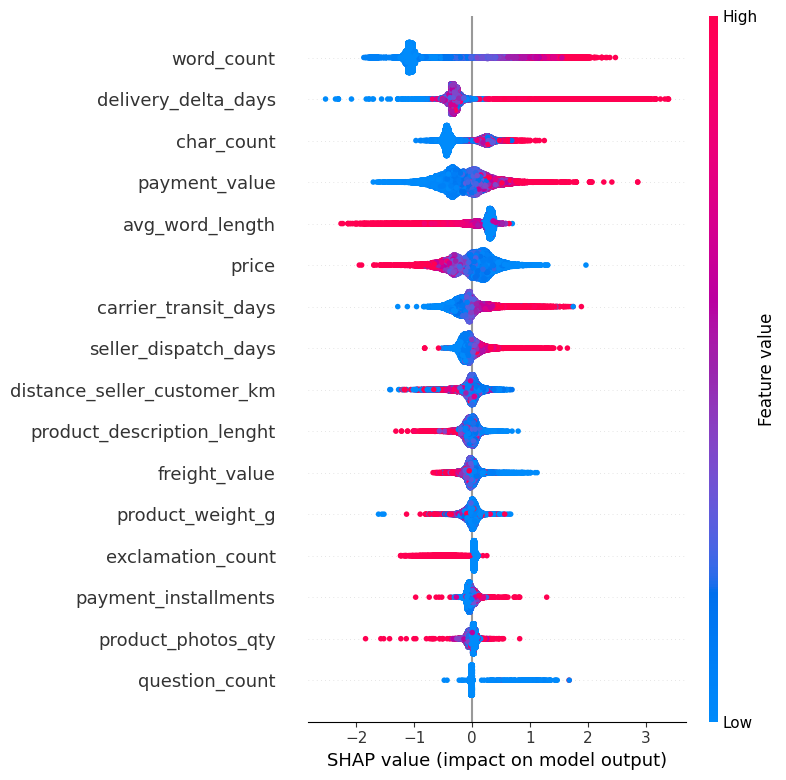

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=FEATURE_COLUMNS)




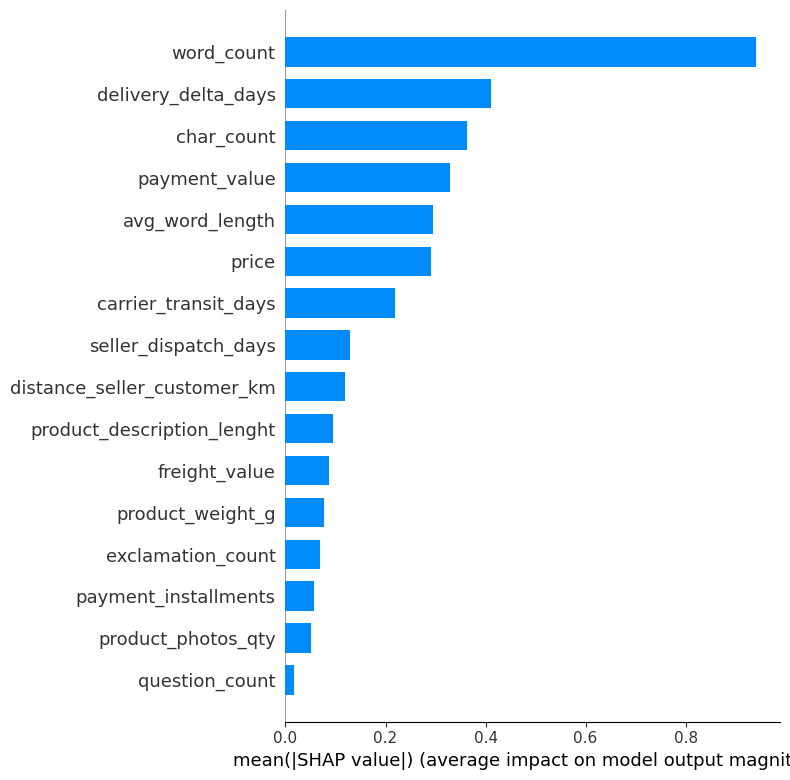

In [75]:
shap.summary_plot(shap_values, X_test, feature_names=FEATURE_COLUMNS, plot_type="bar")